# Area potential
Example for one area (Southern Vietnam) <br/>
Linh Ho (2025-04-14)

In [1]:
import os
import xarray as xr
import rioxarray as rxr

# import pandas as pd
# import geopandas as gpd
# import numpy as np

# import hvplot.xarray
# import matplotlib.pyplot as plt

from select_rasters import process_all_rasters
import prepare_land_cover
import prepare_settlement
import apply_technical_mask

                     land_cover_type max_slope is_settlement max_depth
pv-rooftop                   [URBAN]       NaN          True       NaN
pv-open-field          [FARM, OTHER]         3         False       NaN
wind-onshore   [FARM, FOREST, OTHER]        20         False       NaN
wind-offshore          land_sea_mask       NaN           NaN       -50


In [2]:
path_main = os.getcwd()

path_input = {
    "land_cover": path_main + "/data/cropped_land_cover.tif",
    "land_sea_mask": path_main + "/data/cropped_land_sea_mask.tif",
    "slope": path_main + "/data/cropped_slope.tif",
    "settlement": path_main + "/data/cropped_settlement.tif",
    "bathymetry": path_main + "/data/cropped_bathymetry.tif",
}
path_output = path_main + "/output/"
path_protected_area = path_main + "/data/protected-area"
path_input

{'land_cover': '/home/linhho/Documents/My_research/area-potential/data/cropped_land_cover.tif',
 'land_sea_mask': '/home/linhho/Documents/My_research/area-potential/data/cropped_land_sea_mask.tif',
 'slope': '/home/linhho/Documents/My_research/area-potential/data/cropped_slope.tif',
 'settlement': '/home/linhho/Documents/My_research/area-potential/data/cropped_settlement.tif',
 'bathymetry': '/home/linhho/Documents/My_research/area-potential/data/cropped_bathymetry.tif'}

### Select area of interest
By bounds of the raster, convert to the sample projection (default "EPSG:4326") and resolution (default 30 arcsec)


In [3]:
bounds = (105, 10, 110, 15)  # (minx, miny, maxx, maxy)
resolution = 30 / 3600
processed_rasters = process_all_rasters(
    path_input, bounds, resolution, path_protected_areas=path_protected_area
)
processed_rasters

Processing variable: land_cover
(600, 600)
Processing variable: land_sea_mask
(600, 600)
Processing variable: slope
(600, 600)
Processing variable: settlement
(600, 600)
Processing variable: bathymetry
(600, 600)


<xarray.Dataset> Size: 9MB
Dimensions:        (x: 600, y: 600)
Coordinates:
    band           int64 8B 1
  * x              (x) float64 5kB 105.0 105.0 105.0 105.0 ... 110.0 110.0 110.0
  * y              (y) float64 5kB 15.0 14.99 14.98 14.97 ... 10.02 10.01 10.0
    spatial_ref    int64 8B 0
Data variables:
    land_cover     (y, x) float32 1MB 14.0 14.0 14.0 14.0 ... 210.0 210.0 210.0
    land_sea_mask  (y, x) float32 1MB nan nan nan nan nan ... 1.0 1.0 1.0 1.0
    slope          (y, x) float32 1MB 0.0001803 0.0001803 0.0002625 ... nan nan
    settlement     (y, x) float64 3MB 5.618e+03 5.7e+03 1.094e+04 ... nan nan
    bathymetry     (y, x) float32 1MB 136.0 134.0 133.0 ... -1.482e+03 nan

Plot the input data before applying technical masks

**NOTE**
The land sea mask here (from the same dataset of land cover GlobCover) is not correct, as many areas at river mounths are considered as sea instead of inland, resulting in an overestimation of areas suitable for wind power offshore.

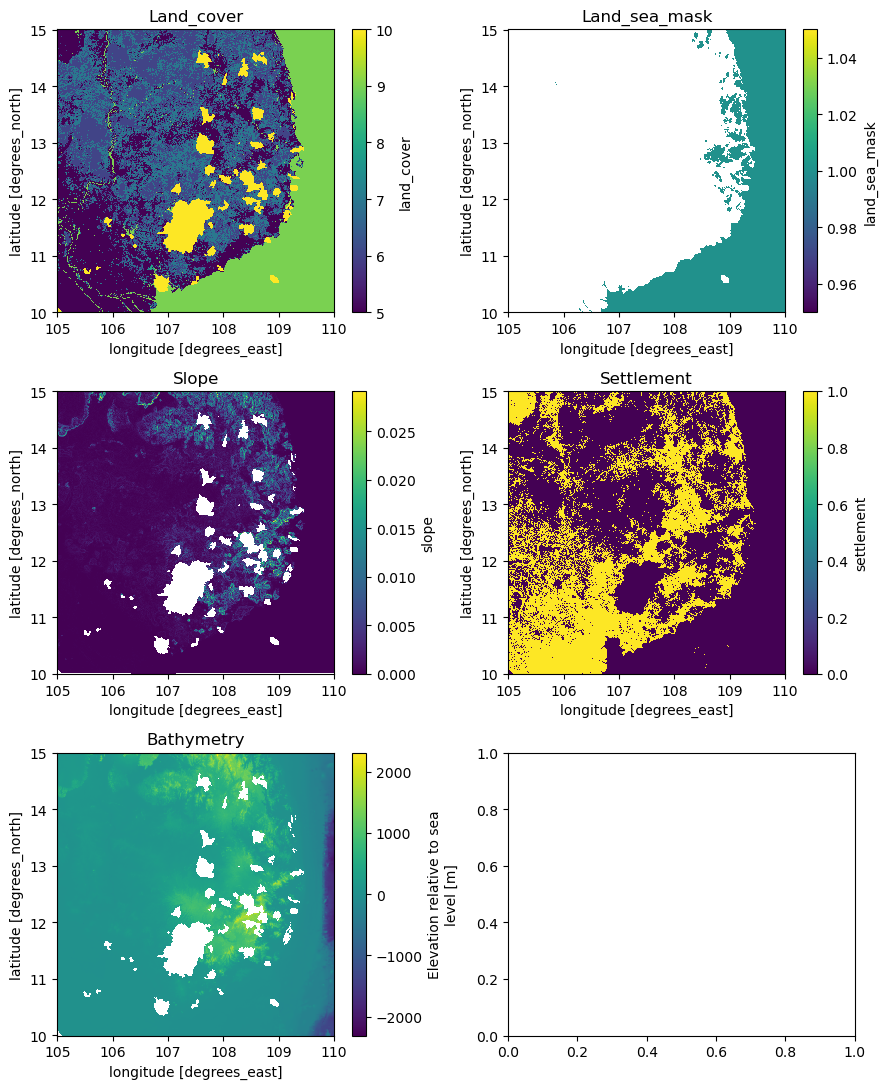

In [12]:
import matplotlib.pyplot as plt
import math

# Create a figure with 2-column subplots
nvars = len(processed_rasters.data_vars)
fig, axes = plt.subplots(ncols=2, nrows=math.ceil(nvars/2), figsize=(9, 11))


# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each variable
for i, var in enumerate(processed_rasters.data_vars):
    processed_rasters[var].plot(ax=axes[i], cmap="viridis", add_colorbar=True)
    axes[i].set_title(var.replace("-", " ").capitalize())

# Adjust layout
plt.tight_layout()
plt.show()
# Set axis labels and aspect ratio for lon/lat maps
for ax in axes:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect("equal")

### Prepare variables to be compatible with the technical mask

In [5]:
from prepare_land_cover import convert_GlobCover_to_CoverType

processed_rasters["land_cover"] = convert_GlobCover_to_CoverType(
    processed_rasters["land_cover"]
)
processed_rasters["land_cover"]

<xarray.DataArray 'land_cover' (y: 600, x: 600)> Size: 1MB
array([[ 5.,  5.,  5., ...,  9.,  9.,  9.],
       [ 5.,  5.,  5., ...,  9.,  9.,  9.],
       [ 5.,  5.,  5., ...,  9.,  9.,  9.],
       ...,
       [ 9., 10., 10., ...,  9.,  9.,  9.],
       [ 9., 10., 10., ...,  9.,  9.,  9.],
       [ 9., 10., 10., ...,  9.,  9.,  9.]], dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 5kB 105.0 105.0 105.0 105.0 ... 110.0 110.0 110.0
  * y            (y) float64 5kB 15.0 14.99 14.98 14.97 ... 10.02 10.01 10.0
    spatial_ref  int64 8B 0
Attributes:
    Authors:              Sophie Bontemps <sophie.bontemps@uclouvain.be>,Eric...
    Copyright:            Copyright ©UCL Geomatics, BELGIUM 1999-2010
    Generate by:          gdal_mean
    process begin time:   2010-12-23T09:49:37
    process files:        CL5_GLOBCOVER-L5_CLASSIF_2009_V2.3.20101220.tif
    process finish time:  2010-12-23T09:57:38
    AREA_OR_POINT:        Area
    scale_factor:         1.0
    add_offset:           0.0

In [6]:
from prepare_settlement import is_settlement

processed_rasters["settlement"] = is_settlement(
    processed_rasters["settlement"], bounds=bounds, resolution=resolution
)
processed_rasters["settlement"]

<xarray.DataArray 'settlement' (y: 600, x: 600)> Size: 360kB
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    band         int64 8B 1
  * x            (x) float64 5kB 105.0 105.0 105.0 105.0 ... 110.0 110.0 110.0
  * y            (y) float64 5kB 15.0 14.99 14.98 14.97 ... 10.02 10.01 10.0
    spatial_ref  int64 8B 0

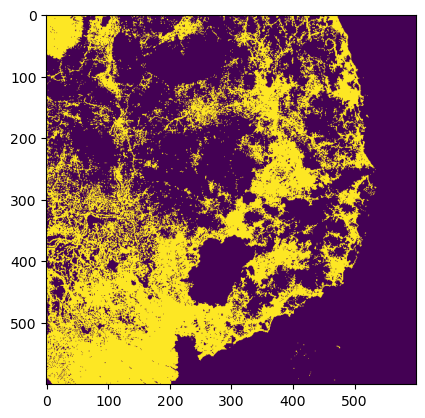

In [7]:
import matplotlib.pyplot as plt

plt.imshow(processed_rasters["settlement"], cmap="viridis")

In [8]:
from apply_technical_mask import technical_mask

masked_technical = technical_mask(processed_rasters)
masked_technical

<xarray.Dataset> Size: 1MB
Dimensions:        (x: 600, y: 600)
Coordinates:
    band           int64 8B 1
  * x              (x) float64 5kB 105.0 105.0 105.0 105.0 ... 110.0 110.0 110.0
  * y              (y) float64 5kB 15.0 14.99 14.98 14.97 ... 10.02 10.01 10.0
    spatial_ref    int64 8B 0
Data variables:
    pv-rooftop     (y, x) bool 360kB True True True True ... False False False
    pv-open-field  (y, x) bool 360kB False False False ... False False False
    wind-onshore   (y, x) bool 360kB False False False ... False False False
    wind-offshore  (y, x) bool 360kB False False False ... False False False

### Note
- PV rooftop: if account for land cover is 'URBAN', then very little area is available for PV rooftop -> need to check URBAN type in land cover classification. Currently, only use settlement (built up surface > 1%) as the sole criteria

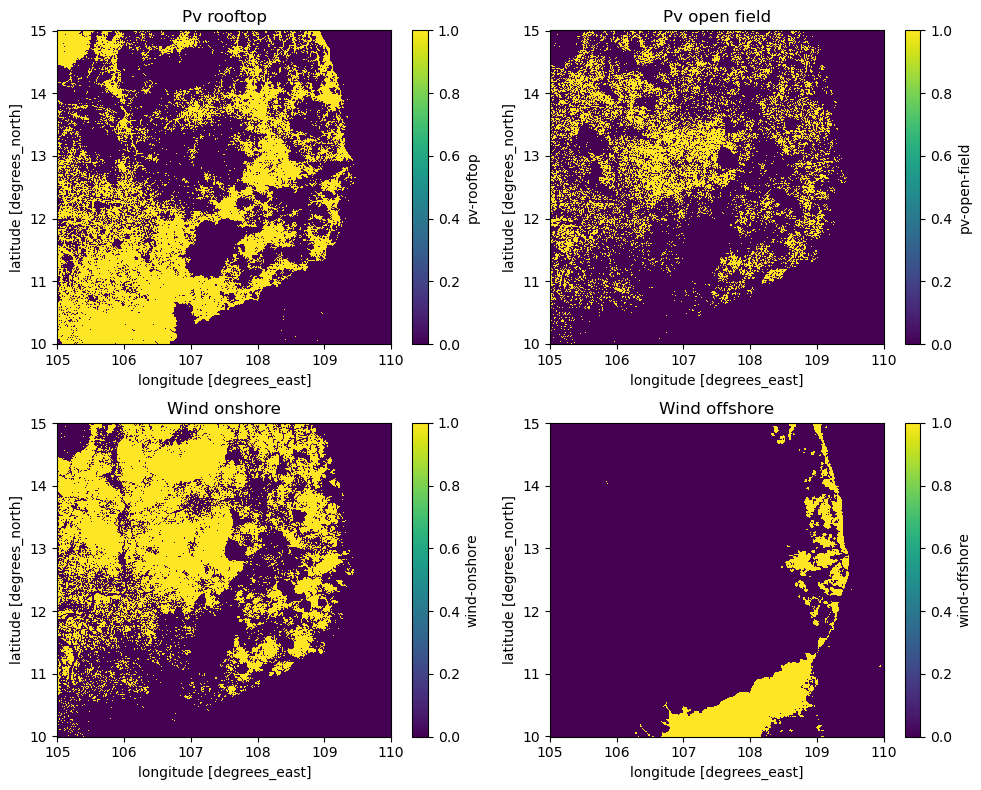

In [9]:
import matplotlib.pyplot as plt
from apply_technical_mask import technical_table

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each variable
for i, var in enumerate(technical_table.index):
    masked_technical[var].plot(ax=axes[i], cmap="viridis", add_colorbar=True)
    axes[i].set_title(var.replace("-", " ").capitalize())

# Adjust layout
plt.tight_layout()
plt.show()
# Set axis labels and aspect ratio for lon/lat maps
for ax in axes:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_aspect("equal")